<a href="https://colab.research.google.com/github/HansAzharr/ML-Material-Screening/blob/main/04_Feature_Reduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap

In [ ]:
import pandas as pd
import numpy as np
import os
import sys
import random
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import joblib # For saving and loading models and scaler


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, KFold
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.multioutput import MultiOutputRegressor # import for multi-output handling

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor



## Load files

In [ ]:
# Define paths to saved model, scaler, and data

model_folder_path = '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Model'
data_output_folder_path = '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Data/Training_Data' # Where X_test_scaled.csv is saved


scaler_filename = os.path.join(model_folder_path, "scaler_X_v2.joblib")
feature_names_filename = os.path.join(model_folder_path, "feature_column_names_v2.joblib")
X_test_filename = os.path.join(data_output_folder_path, "X_test_scaled.csv")
Y_test_filename = os.path.join(data_output_folder_path, "Y_test.csv")
X_train_filename = os.path.join(data_output_folder_path, "X_train_scaled.csv")
Y_train_filename = os.path.join(data_output_folder_path, "Y_train.csv")

# Define filenames for the models
xgb_model_filename = os.path.join(model_folder_path, "tuned_xgboost_multi_output_model_v2.joblib")
rf_model_filename = os.path.join(model_folder_path, "tuned_random_forest_multi_output_model_v2.joblib")
lgbm_model_filename = os.path.join(model_folder_path, "tuned_lightgbm_multi_output_model_v2.joblib")


print(f"XGBoost Model will be loaded from: '{xgb_model_filename}'")
print(f"Random Forest Model will be loaded from: '{rf_model_filename}'")
print(f"LightGBM Model will be loaded from: '{lgbm_model_filename}'")
print(f"Scaler will be loaded from: '{scaler_filename}'")
print(f"Feature names will be loaded from: '{feature_names_filename}'")
print(f"X_test data will be loaded from: '{X_test_filename}'")
print(f"Y_test data will be loaded from: '{Y_test_filename}'")
print(f"X_train data will be loaded from: '{X_train_filename}'")
print(f"Y_train data will be loaded from: '{Y_train_filename}'")

XGBoost Model will be loaded from: '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Model/tuned_xgboost_multi_output_model_v2.joblib'
Random Forest Model will be loaded from: '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Model/tuned_random_forest_multi_output_model_v2.joblib'
LightGBM Model will be loaded from: '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Model/tuned_lightgbm_multi_output_model_v2.joblib'
Scaler will be loaded from: '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Model/scaler_X_v2.joblib'
Feature names will be loaded from: '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Model/feature_column_names_v2.joblib'
X_test data will be loaded from: '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Data/Training_Data/X_test_scaled.csv'
Y_test data will be loaded from: '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Data/Training_Data/Y_test.csv'
X_train data w

In [ ]:
# Load Model, Scaler, and Feature Names

try:
    # Load all three models
    loaded_xgboost_model = joblib.load(xgb_model_filename) # XGBoost model
    loaded_random_forest_model = joblib.load(rf_model_filename) # Random Forest model
    loaded_lightgbm_model = joblib.load(lgbm_model_filename) # LightGBM model


    loaded_scaler_X = joblib.load(scaler_filename)
    loaded_feature_names = joblib.load(feature_names_filename)
    print("Models, scaler, and feature names loaded successfully.")
    print(f"Type of loaded XGBoost model: {type(loaded_xgboost_model)}")
    print(f"Type of loaded Random Forest model: {type(loaded_random_forest_model)}")
    print(f"Type of loaded LightGBM model: {type(loaded_lightgbm_model)}")
    print(f"Type of loaded scaler: {type(loaded_scaler_X)}")

    # Inspect loaded_feature_names
    print("\n--- Inspection of loaded_feature_names ---")
    print(f"Type of loaded_feature_names: {type(loaded_feature_names)}")
    print(f"Number of feature names loaded: {len(loaded_feature_names)}")
    print(f"First 5 feature names: {loaded_feature_names[:5]}")
    print(f"Last 5 feature names: {loaded_feature_names[-5:]}")


except Exception as e:
    print(f"Error loading models, scaler, or feature names: {e}")
    sys.exit("Exiting due to critical loading error.") # Exit if these critical components can't be loaded

/usr/lib/python3.12/pickle.py:1760: UserWarning: [12:02:41] WARNING: /workspace/src/collective/../data/../common/error_msg.h:82: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  setstate(state)


Models, scaler, and feature names loaded successfully.
Type of loaded XGBoost model: <class 'sklearn.multioutput.MultiOutputRegressor'>
Type of loaded Random Forest model: <class 'sklearn.multioutput.MultiOutputRegressor'>
Type of loaded LightGBM model: <class 'sklearn.multioutput.MultiOutputRegressor'>
Type of loaded scaler: <class 'sklearn.preprocessing._data.StandardScaler'>

--- Inspection of loaded_feature_names ---
Type of loaded_feature_names: <class 'list'>
Number of feature names loaded: 49
First 5 feature names: ['density', 'nelements', 'volume', 'band_gap', 'total_magnetization']
Last 5 feature names: ['theoretical_True', 'exp_band_gap', 'exp_energy_vol', 'theo_band_gap', 'theo_energy_vol']


In [ ]:
# Load the Training Data (X_train_scaled and Y_train)
print("--- Loading Training Data ---")
try:
    # Load X_train_scaled.csv
    # index_col=0 is crucial if you saved with index=True
    X_train_loaded_df_full = pd.read_csv(X_train_filename, index_col=0)

    # Load Y_train.csv
    Y_train_loaded_df = pd.read_csv(Y_train_filename, index_col=0)

    print("Training data loaded successfully.")
    print(f"Shape of loaded X_train_loaded_df_full: {X_train_loaded_df_full.shape}")
    print(f"Shape of loaded Y_train_loaded_df: {Y_train_loaded_df.shape}")

except Exception as e:
    print(f"Error loading training data: {e}")
    sys.exit("Exiting due to critical training data loading error.") # Exit if training data can't be loaded


print("\nX_train_loaded_df_full head:")
display(X_train_loaded_df_full.head())

print("\nY_train_loaded_df head:")
display(Y_train_loaded_df.head())

--- Loading Training Data ---
Training data loaded successfully.
Shape of loaded X_train_loaded_df_full: (2756, 51)
Shape of loaded Y_train_loaded_df: (2756, 3)

X_train_loaded_df_full head:


,density,nelements,volume,band_gap,total_magnetization,energy_grav,energy_vol,num_steps,max_voltage_step,stability_discharge,...,is_metal_False,is_metal_True,theoretical_False,theoretical_True,exp_band_gap,exp_energy_vol,theo_band_gap,theo_energy_vol,material_id,formula_pretty
2553,-0.169257,0.665793,-0.404032,-0.808833,-0.611204,1.285479,1.129724,-0.338524,-0.280721,-0.715951,...,0,1,0,1,-0.000000,0.000000,-0.808833,1.129724,mp-765340,CoNi(PO4)2
289,0.497746,-0.656199,-1.191936,0.643312,-0.786030,-0.149661,-0.044021,-0.338524,-0.280721,2.491218,...,1,0,0,1,0.000000,-0.000000,0.643312,-0.044021,mp-1101381,SbOF3
1589,-0.193005,-0.656199,1.858524,-0.808833,2.326681,-0.417245,-0.343738,-0.338524,-0.280721,-0.732896,...,0,1,0,1,-0.000000,-0.000000,-0.808833,-0.343738,mp-705347,Co6P7O24
222,3.364165,0.665793,-0.894973,1.489654,-0.786029,-1.007493,-1.127799,-0.338524,-0.280721,2.823654,...,1,0,1,0,1.489654,-1.127799,0.000000,-0.000000,mp-1078392,YSb(PbO3)2
751,-0.235335,-1.978191,-0.646339,-0.808833,-0.126637,7.473805,5.563907,-0.338524,-0.280721,-0.373854,...,0,1,0,1,-0.000000,0.000000,-0.808833,5.563907,mp-1442954,CrS2



Y_train_loaded_df head:


,theoretical_capacity_grav,average_voltage,energy_above_hull
2553,166.752970,4.657738,0.173631
289,244.695781,0.864578,0.046806
1589,27.879234,3.808891,0.011383
222,71.914834,-1.755416,0.022194
751,112.049511,28.679700,0.029461


In [ ]:
#  Define Target KPIs
target_kpis = ['theoretical_capacity_grav', 'average_voltage', 'energy_above_hull']
print(f"\nTarget KPIs for analysis: {target_kpis}")

# Load the Test Data (X_test_scaled and Y_test)
print("\n--- Loading Test Data ---")
try:
    # Load X_test_scaled.csv (which includes material_id and formula_pretty)
    # index_col=0 is crucial if you saved with index=True
    X_test_loaded_df_full = pd.read_csv(X_test_filename, index_col=0)

    # Load Y_test.csv
    Y_test_loaded_df = pd.read_csv(Y_test_filename, index_col=0)

    print("Test data loaded successfully.")
    print(f"Shape of loaded X_test_loaded_df_full: {X_test_loaded_df_full.shape}")
    print(f"Shape of loaded Y_test_loaded_df: {Y_test_loaded_df.shape}")

except Exception as e:
    print(f"Error loading test data: {e}")
    sys.exit("Exiting due to critical data loading error.") # Exit if test data can't be loaded


Target KPIs for analysis: ['theoretical_capacity_grav', 'average_voltage', 'energy_above_hull']

--- Loading Test Data ---
Test data loaded successfully.
Shape of loaded X_test_loaded_df_full: (689, 51)
Shape of loaded Y_test_loaded_df: (689, 3)


## Model Evaluation (Recap)

In [ ]:
# Separate material_id and formula_pretty from features

if 'material_id' in X_test_loaded_df_full.columns and 'formula_pretty' in X_test_loaded_df_full.columns:
    material_ids = X_test_loaded_df_full['material_id']
    formula_pretties = X_test_loaded_df_full['formula_pretty']

    # Select only the features needed for the model (using the loaded_feature_names)
    try:
        X_test_scaled = X_test_loaded_df_full[loaded_feature_names]
        print(f"Selected {len(loaded_feature_names)} features from X_test_loaded_df_full for modeling.")
    except KeyError as e:
        print(f"Error: One or more feature names from 'loaded_feature_names' not found in 'X_test_loaded_df_full'.")
        print(f"Missing feature: {e}")
        print(f"Columns in loaded CSV: {X_test_loaded_df_full.columns.tolist()}")
        print(f"Features expected by model: {loaded_feature_names}")
        sys.exit("Exiting due to feature mismatch during selection.")
else:
    print("Warning: 'material_id' or 'formula_pretty' not found in loaded X_test data. Assuming all columns are features.")
    X_test_scaled = X_test_loaded_df_full.copy()
    material_ids = X_test_scaled.index.to_series() # Use index if no material_id column
    formula_pretties = X_test_scaled.index.to_series() # Placeholder if no formula_pretty

# Ensure y_test is a DataFrame for consistency
y_test = Y_test_loaded_df.copy()

print(f"Final X_test_scaled shape for prediction: {X_test_scaled.shape}")
print(f"Final y_test shape: {y_test.shape}")
print(f"Columns in X_test_scaled (first 5): {X_test_scaled.columns.tolist()[:5]}")
print(f"Columns in X_test_scaled (last 5): {X_test_scaled.columns.tolist()[-5:]}")


Selected 49 features from X_test_loaded_df_full for modeling.
Final X_test_scaled shape for prediction: (689, 49)
Final y_test shape: (689, 3)
Columns in X_test_scaled (first 5): ['density', 'nelements', 'volume', 'band_gap', 'total_magnetization']
Columns in X_test_scaled (last 5): ['theoretical_True', 'exp_band_gap', 'exp_energy_vol', 'theo_band_gap', 'theo_energy_vol']


## Model Evaluation for all 3 models (Recap)

In [ ]:
# Evaluate the loaded models on the entire test set (49-feature model)

print("\n--- Evaluating Models on the Entire Test Set (49-feature model) ---")

# Use the full 49-feature scaled test data and the corresponding y_test data
X_test_evaluation = X_test_scaled # Use the scaled features
y_test_evaluation = y_test # Use the actual target values

# Create a dictionary of models to evaluate
models_to_evaluate = {
    'XGBoost': loaded_xgboost_model,
    'Random Forest': loaded_random_forest_model,
    'LightGBM': loaded_lightgbm_model
}

all_metrics_results = {}

for model_name, model in models_to_evaluate.items():
    print(f"\n--- Evaluating {model_name} Model ---")

    # Make predictions on the entire test set
    print(f"Predicting with {model_name} on test set of shape: {X_test_evaluation.shape}")
    y_pred = model.predict(X_test_evaluation)
    print("Prediction complete.")

    # Calculate metrics for each target KPI
    print(f"\n--- Performance Metrics for {model_name} ---")

    results = {}

    for i, kpi in enumerate(target_kpis):
        actual = y_test_evaluation[kpi]
        predicted = y_pred[:, i] # Select the predictions for the i-th target

        # Calculate metrics
        r2 = r2_score(actual, predicted)
        mae = mean_absolute_error(actual, predicted)
        rmse = np.sqrt(mean_squared_error(actual, predicted)) # Calculate RMSE manually from MSE

        print(f"\nMetrics for KPI: {kpi}")
        print(f"  R2 Score: {r2:.4f}")
        print(f"  MAE (Absolute Error):      {mae:.4f}") # Label MAE as Absolute Error
        print(f"  RMSE:     {rmse:.4f}")


        # Store results
        results[kpi] = {
            'R2 Score': r2,
            'MAE': mae,
            'RMSE': rmse,
        }

    print(f"\n--- Average Performance Metrics ({model_name}) ---")
    avg_r2 = np.mean([res['R2 Score'] for res in results.values()])
    avg_mae = np.mean([res['MAE'] for res in results.values()])
    avg_rmse = np.mean([res['RMSE'] for res in results.values()])


    print(f"  Average R2 Score: {avg_r2:.4f}")
    print(f"  Average MAE:      {avg_mae:.4f}")
    print(f"  Average RMSE:     {avg_rmse:.4f}")

    # Store metrics for this model in the overall results dictionary
    all_metrics_results[model_name] = pd.DataFrame(results).T


print("\n--- Overall Metrics Summary DataFrame ---")
# Combine all metrics DataFrames into a single DataFrame for easy comparison
# Use a multi-level column index for clarity
combined_metrics_df = pd.concat(all_metrics_results, axis=1)
display(combined_metrics_df)

metrics_df = all_metrics_results[list(models_to_evaluate.keys())[-1]] # Keep the last one for backward compatibility if needed (e.g., comparison cell)


--- Evaluating Models on the Entire Test Set (49-feature model) ---

--- Evaluating XGBoost Model ---
Predicting with XGBoost on test set of shape: (689, 49)
Prediction complete.

--- Performance Metrics for XGBoost ---

Metrics for KPI: theoretical_capacity_grav
  R2 Score: 0.6534
  MAE (Absolute Error):      18.2208
  RMSE:     42.0546

Metrics for KPI: average_voltage
  R2 Score: 0.8449
  MAE (Absolute Error):      0.3676
  RMSE:     1.5609

Metrics for KPI: energy_above_hull
  R2 Score: 0.5002
  MAE (Absolute Error):      0.0236
  RMSE:     0.0326

--- Average Performance Metrics (XGBoost) ---
  Average R2 Score: 0.6662
  Average MAE:      6.2040
  Average RMSE:     14.5494

--- Evaluating Random Forest Model ---
Predicting with Random Forest on test set of shape: (689, 49)
Prediction complete.

--- Performance Metrics for Random Forest ---

Metrics for KPI: theoretical_capacity_grav
  R2 Score: 0.6406
  MAE (Absolute Error):      19.0836
  RMSE:     42.8224

Metrics for KPI: aver

XGBoost                       Random Forest  \
                           R2 Score        MAE       RMSE      R2 Score   
theoretical_capacity_grav  0.653395  18.220798  42.054630      0.640623   
average_voltage            0.844870   0.367621   1.560931      0.892373   
energy_above_hull          0.500242   0.023619   0.032587      0.449566   

                                                 LightGBM             \
                                 MAE       RMSE  R2 Score        MAE   
theoretical_capacity_grav  19.083629  42.822411  0.809285  18.091932   
average_voltage             0.381397   1.300159  0.522299   0.479379   
energy_above_hull           0.025094   0.034200  0.450508   0.024679   

                                      
                                RMSE  
theoretical_capacity_grav  31.195233  
average_voltage             2.739142  
energy_above_hull           0.034170

In [ ]:
#  Quick Model Test: Predict for a Random Material ID
print("\n--- Quick Model Test on a Random Material (All Loaded Models) ---")

try:
    # Create a dictionary of models to test
    models_to_test = {
        'XGBoost': loaded_xgboost_model,
        'Random Forest': loaded_random_forest_model,
        'LightGBM': loaded_lightgbm_model
    }

    # Choose a random index from the test set (use the same index for all models for comparison)
    random_idx = random.randint(0, X_test_scaled.shape[0] - 1)

    # Get the material ID and formula for this random index
    test_material_id = material_ids.iloc[random_idx]
    test_formula_pretty = formula_pretties.iloc[random_idx]

    print(f"Testing prediction for Random Material ID: {test_material_id}")
    print(f"Formula: {test_formula_pretty}")
    print(f"Using test set index: {random_idx}")

    # Get the scaled features for this specific material
    material_scaled_features = X_test_scaled.iloc[random_idx:random_idx+1]

    # Get the actual KPIs for comparison
    actual_kpis = y_test.iloc[random_idx].values # .values to get numpy array

    # Display results
    print("\n--- Results for Randomly Selected Material (All Models) ---")
    print(f"Material ID: {test_material_id}")
    print(f"Formula: {test_formula_pretty}")
    print(f"Actual KPIs:")
    for i, kpi in enumerate(target_kpis):
        print(f"  {kpi}: {actual_kpis[i]:.4f}")

    print("\n--- Predicted KPI Comparisons ---")
    for model_name, model in models_to_test.items():
        print(f"\n--- {model_name} Predictions ---")
        try:
            # Make the prediction using the current model
            predicted_kpis = model.predict(material_scaled_features)[0] # [0] to get the single array of predictions

            for i, kpi in enumerate(target_kpis):
                predicted = predicted_kpis[i]
                actual = actual_kpis[i]

                print(f"  {kpi}:")
                print(f"    Predicted: {predicted:.4f}")

                # Calculate and display Absolute Error
                absolute_error = abs(predicted - actual)
                print(f"    Absolute Error: {absolute_error:.4f}")

                # Calculate and display Relative Error (Percentage Error)
                if actual != 0:
                    relative_error_percent = ((predicted - actual) / actual) * 100
                    print(f"    Relative Error: {relative_error_percent:.2f}%")
                else:
                    print(f"    Relative Error: N/A (Actual KPI is zero)")

        except Exception as e:
            print(f"  Error predicting with {model_name}: {e}")

except NameError as e:
    print("\nQuick model test skipped.")
    print(f"  Reason: One or more model variables are not defined: {e}")
except Exception as e:
    print("\nAn unexpected error occurred during the quick model test.")
    print(f"  Error: {e}")


--- Quick Model Test on a Random Material (All Loaded Models) ---
Testing prediction for Random Material ID: mp-777375
Formula: LiMn2(BO3)2
Using test set index: 333

--- Results for Randomly Selected Material (All Models) ---
Material ID: mp-777375
Formula: LiMn2(BO3)2
Actual KPIs:
  theoretical_capacity_grav: 56.3279
  average_voltage: 2.7514
  energy_above_hull: 0.0746

--- Predicted KPI Comparisons ---

--- XGBoost Predictions ---
  theoretical_capacity_grav:
    Predicted: 54.9251
    Absolute Error: 1.4028
    Relative Error: -2.49%
  average_voltage:
    Predicted: 2.6730
    Absolute Error: 0.0784
    Relative Error: -2.85%
  energy_above_hull:
    Predicted: 0.0724
    Absolute Error: 0.0022
    Relative Error: -2.92%

--- Random Forest Predictions ---
  theoretical_capacity_grav:
    Predicted: 55.4906
    Absolute Error: 0.8373
    Relative Error: -1.49%
  average_voltage:
    Predicted: 2.8803
    Absolute Error: 0.1289
    Relative Error: 4.68%
  energy_above_hull:
    Pr

## Feature Importance (Recap)

In [ ]:
print("\n--- Calculating Feature Importance ---")

# Create a dictionary of models for which to calculate feature importance
models_for_importance = {
    'XGBoost': loaded_xgboost_model,
    'Random Forest': loaded_random_forest_model,
    'LightGBM': loaded_lightgbm_model
}

all_models_importance_results = {}

for model_name, model in models_for_importance.items():
    print(f"\n--- Feature Importance for {model_name} Model ---")

    if isinstance(model, MultiOutputRegressor):
        estimators = model.estimators_

        if estimators:
            print(f"MultiOutputRegressor for {model_name} contains {len(estimators)} estimators.")
            print(f"Assuming corresponding order to target KPIs: {target_kpis}")

            feature_importances_dict = {}
            importance_dfs = [] # List to store individual importance dataframes for this model

            for i, kpi in enumerate(target_kpis):
                estimator = estimators[i]
                if hasattr(estimator, 'feature_importances_'):
                    print(f"  Accessing feature importances for output: {kpi} ({model_name})")
                    importances = estimator.feature_importances_
                    feature_importances_dict[kpi] = importances

                    importance_df = pd.DataFrame({
                        'Feature': loaded_feature_names,
                        f'Importance_{kpi}': importances
                    })
                    importance_dfs.append(importance_df)

                    importance_df_sorted = importance_df.sort_values(by=f'Importance_{kpi}', ascending=False).reset_index(drop=True)
                    print(f"\nTop 10 Features by Importance for {kpi} ({model_name}):")
                    display(importance_df_sorted.head(10))

                else:
                     print(f"  Estimator for {kpi} ({model_name}) does not have 'feature_importances_'. Cannot get importance for this output.")
                     feature_importances_dict[kpi] = None

            # Analyze Importances Across Outputs for this model
            print(f"\n--- Analyzing Feature Importances Across All Outputs ({model_name}) ---")

            if importance_dfs:
                combined_importance_df_model = importance_dfs[0]
                for i in range(1, len(importance_dfs)):
                     combined_importance_df_model = pd.merge(combined_importance_df_model, importance_dfs[i], on='Feature', how='left')

                print(f"\nCombined Feature Importances DataFrame ({model_name}):")
                display(combined_importance_df_model.head())

                importance_cols = [col for col in combined_importance_df_model.columns if col.startswith('Importance_')]
                if importance_cols:
                    combined_importance_df_model['Average_Importance'] = combined_importance_df_model[importance_cols].mean(axis=1)
                    combined_importance_df_sorted_avg_model = combined_importance_df_model.sort_values(by='Average_Importance', ascending=False).reset_index(drop=True)

                    print(f"\nTop 10 Features by Average Importance Across All KPIs ({model_name}):")
                    display(combined_importance_df_sorted_avg_model[['Feature', 'Average_Importance'] + importance_cols].head(10))

                    # Store the combined importance DataFrame for this model
                    all_models_importance_results[model_name] = combined_importance_df_sorted_avg_model

            else:
                print(f"No feature importances available from any of the base estimators for {model_name}.")

        else:
            print(f"MultiOutputRegressor.estimators_ list for {model_name} is empty. Cannot access base estimators for importance.")

    elif hasattr(model, 'feature_importances_'):
        print(f"{model_name} directly provides feature_importances_ (assuming single output or compatible structure).")
        importances = model.feature_importances_
        importance_df = pd.DataFrame({
            'Feature': loaded_feature_names,
            f'Importance_{model_name}': importances
        })
        importance_df_sorted = importance_df.sort_values(by=f'Importance_{model_name}', ascending=False).reset_index(drop=True)
        print(f"\nTop 10 Features by Importance ({model_name}):")
        display(importance_df_sorted.head(10))
        # Store the importance DataFrame for this model
        all_models_importance_results[model_name] = importance_df_sorted


    else:
        print(f"The loaded model '{model_name}' does not have a 'feature_importances_' attribute.")
        print("Feature importance calculation is not directly supported for this model type.")



--- Calculating Feature Importance ---

--- Feature Importance for XGBoost Model ---
MultiOutputRegressor for XGBoost contains 3 estimators.
Assuming corresponding order to target KPIs: ['theoretical_capacity_grav', 'average_voltage', 'energy_above_hull']
  Accessing feature importances for output: theoretical_capacity_grav (XGBoost)

Top 10 Features by Importance for theoretical_capacity_grav (XGBoost):


,Feature,Importance_theoretical_capacity_grav
0,max_electronegativity,0.770391
1,crystal_system_Hexagonal,0.185836
2,atomic_weight_ion,0.007658
3,energy_grav,0.005462
4,stability_discharge,0.004287
5,max_atomic_mass,0.003935
6,ionic_radius_ion,0.003750
7,energy_vol,0.002268
8,max_voltage_step,0.002267
9,min_covalent_radius,0.001619


  Accessing feature importances for output: average_voltage (XGBoost)

Top 10 Features by Importance for average_voltage (XGBoost):


,Feature,Importance_average_voltage
0,theo_energy_vol,0.850181
1,energy_grav,0.051995
2,atomic_weight_ion,0.033558
3,avg_atomic_number,0.029597
4,energy_vol,0.019496
5,avg_covalent_radius,0.001793
6,theo_band_gap,0.001310
7,avg_electronegativity,0.001211
8,max_electronegativity,0.000964
9,min_electronegativity,0.000960


  Accessing feature importances for output: energy_above_hull (XGBoost)

Top 10 Features by Importance for energy_above_hull (XGBoost):


,Feature,Importance_energy_above_hull
0,exp_energy_vol,0.282346
1,theoretical_False,0.187517
2,ionic_radius_ion,0.055834
3,atomic_weight_ion,0.048011
4,min_atomic_number,0.033200
5,min_covalent_radius,0.030954
6,crystal_system_Cubic,0.027611
7,min_electronegativity,0.025830
8,max_atomic_mass,0.020385
9,nelements,0.018769



--- Analyzing Feature Importances Across All Outputs (XGBoost) ---

Combined Feature Importances DataFrame (XGBoost):


,Feature,Importance_theoretical_capacity_grav,Importance_average_voltage,Importance_energy_above_hull
0,density,0.000340,0.000187,0.004183
1,nelements,0.000479,0.000204,0.018769
2,volume,0.000750,0.000374,0.005396
3,band_gap,0.000287,0.000382,0.009877
4,total_magnetization,0.000170,0.000436,0.006224



Top 10 Features by Average Importance Across All KPIs (XGBoost):


,Feature,Average_Importance,Importance_theoretical_capacity_grav,Importance_average_voltage,Importance_energy_above_hull
0,theo_energy_vol,0.288450,0.001331,0.850181,0.013839
1,max_electronegativity,0.261862,0.770391,0.000964,0.014232
2,exp_energy_vol,0.094412,0.000229,0.000659,0.282346
3,crystal_system_Hexagonal,0.063295,0.185836,0.000063,0.003986
4,theoretical_False,0.062593,0.000201,0.000059,0.187517
5,atomic_weight_ion,0.029742,0.007658,0.033558,0.048011
6,energy_grav,0.021389,0.005462,0.051995,0.006710
7,ionic_radius_ion,0.019991,0.003750,0.000390,0.055834
8,avg_atomic_number,0.012978,0.000340,0.029597,0.008996
9,energy_vol,0.012323,0.002268,0.019496,0.015205



--- Feature Importance for Random Forest Model ---
MultiOutputRegressor for Random Forest contains 3 estimators.
Assuming corresponding order to target KPIs: ['theoretical_capacity_grav', 'average_voltage', 'energy_above_hull']
  Accessing feature importances for output: theoretical_capacity_grav (Random Forest)

Top 10 Features by Importance for theoretical_capacity_grav (Random Forest):


,Feature,Importance_theoretical_capacity_grav
0,max_electronegativity,0.393392
1,energy_grav,0.200653
2,energy_vol,0.077230
3,stability_discharge,0.071306
4,crystal_system_Hexagonal,0.068780
5,theo_energy_vol,0.040540
6,avg_electronegativity,0.026458
7,volume,0.020526
8,nsites,0.019747
9,density,0.010119


  Accessing feature importances for output: average_voltage (Random Forest)

Top 10 Features by Importance for average_voltage (Random Forest):


,Feature,Importance_average_voltage
0,energy_grav,0.623230
1,energy_vol,0.261241
2,theo_energy_vol,0.067903
3,working_ion_Li,0.007258
4,stability_discharge,0.003612
5,atomic_weight_ion,0.003184
6,e_fermi,0.003052
7,avg_electronegativity,0.002976
8,atomic_number_ion,0.002385
9,max_atomic_number,0.002347


  Accessing feature importances for output: energy_above_hull (Random Forest)

Top 10 Features by Importance for energy_above_hull (Random Forest):


,Feature,Importance_energy_above_hull
0,stability_discharge,0.085644
1,exp_energy_vol,0.083409
2,density,0.050417
3,e_fermi,0.049391
4,total_magnetization,0.049368
5,std_electronegativity,0.049318
6,energy_vol,0.048791
7,theo_energy_vol,0.048086
8,energy_grav,0.047188
9,band_gap,0.045007



--- Analyzing Feature Importances Across All Outputs (Random Forest) ---

Combined Feature Importances DataFrame (Random Forest):


,Feature,Importance_theoretical_capacity_grav,Importance_average_voltage,Importance_energy_above_hull
0,density,0.010119,0.001344,0.050417
1,nelements,0.001000,0.001709,0.012910
2,volume,0.020526,0.001268,0.042872
3,band_gap,0.002443,0.001176,0.045007
4,total_magnetization,0.005828,0.000912,0.049368



Top 10 Features by Average Importance Across All KPIs (Random Forest):


,Feature,Average_Importance,Importance_theoretical_capacity_grav,Importance_average_voltage,Importance_energy_above_hull
0,energy_grav,0.290357,0.200653,0.623230,0.047188
1,max_electronegativity,0.132359,0.393392,0.000605,0.003081
2,energy_vol,0.129088,0.077230,0.261241,0.048791
3,stability_discharge,0.053521,0.071306,0.003612,0.085644
4,theo_energy_vol,0.052176,0.040540,0.067903,0.048086
5,exp_energy_vol,0.028231,0.001123,0.000161,0.083409
6,crystal_system_Hexagonal,0.023263,0.068780,0.000005,0.001003
7,avg_electronegativity,0.021986,0.026458,0.002976,0.036523
8,volume,0.021555,0.020526,0.001268,0.042872
9,density,0.020627,0.010119,0.001344,0.050417



--- Feature Importance for LightGBM Model ---
MultiOutputRegressor for LightGBM contains 3 estimators.
Assuming corresponding order to target KPIs: ['theoretical_capacity_grav', 'average_voltage', 'energy_above_hull']
  Accessing feature importances for output: theoretical_capacity_grav (LightGBM)

Top 10 Features by Importance for theoretical_capacity_grav (LightGBM):


,Feature,Importance_theoretical_capacity_grav
0,energy_grav,428
1,stability_discharge,426
2,density,406
3,volume,366
4,total_magnetization,350
5,e_fermi,333
6,energy_vol,270
7,avg_covalent_radius,261
8,theo_energy_vol,260
9,avg_electronegativity,238


  Accessing feature importances for output: average_voltage (LightGBM)

Top 10 Features by Importance for average_voltage (LightGBM):


,Feature,Importance_average_voltage
0,energy_grav,439
1,e_fermi,399
2,stability_discharge,393
3,density,356
4,total_magnetization,354
5,volume,352
6,energy_vol,333
7,band_gap,284
8,avg_electronegativity,275
9,std_electronegativity,252


  Accessing feature importances for output: energy_above_hull (LightGBM)

Top 10 Features by Importance for energy_above_hull (LightGBM):


,Feature,Importance_energy_above_hull
0,stability_discharge,429
1,density,413
2,volume,367
3,energy_grav,358
4,e_fermi,347
5,total_magnetization,344
6,avg_covalent_radius,314
7,avg_electronegativity,284
8,std_electronegativity,280
9,avg_atomic_number,265



--- Analyzing Feature Importances Across All Outputs (LightGBM) ---

Combined Feature Importances DataFrame (LightGBM):


,Feature,Importance_theoretical_capacity_grav,Importance_average_voltage,Importance_energy_above_hull
0,density,406,356,413
1,nelements,31,25,60
2,volume,366,352,367
3,band_gap,227,284,247
4,total_magnetization,350,354,344



Top 10 Features by Average Importance Across All KPIs (LightGBM):


,Feature,Average_Importance,Importance_theoretical_capacity_grav,Importance_average_voltage,Importance_energy_above_hull
0,stability_discharge,416.000000,426,393,429
1,energy_grav,408.333333,428,439,358
2,density,391.666667,406,356,413
3,volume,361.666667,366,352,367
4,e_fermi,359.666667,333,399,347
5,total_magnetization,349.333333,350,354,344
6,energy_vol,284.000000,270,333,249
7,avg_electronegativity,265.666667,238,275,284
8,avg_covalent_radius,264.333333,261,218,314
9,band_gap,252.666667,227,284,247



--- Plotting Feature Importances for Each Model ---

--- Plotting Feature Importances for XGBoost ---

--- Plotting Feature Importances per KPI for XGBoost ---


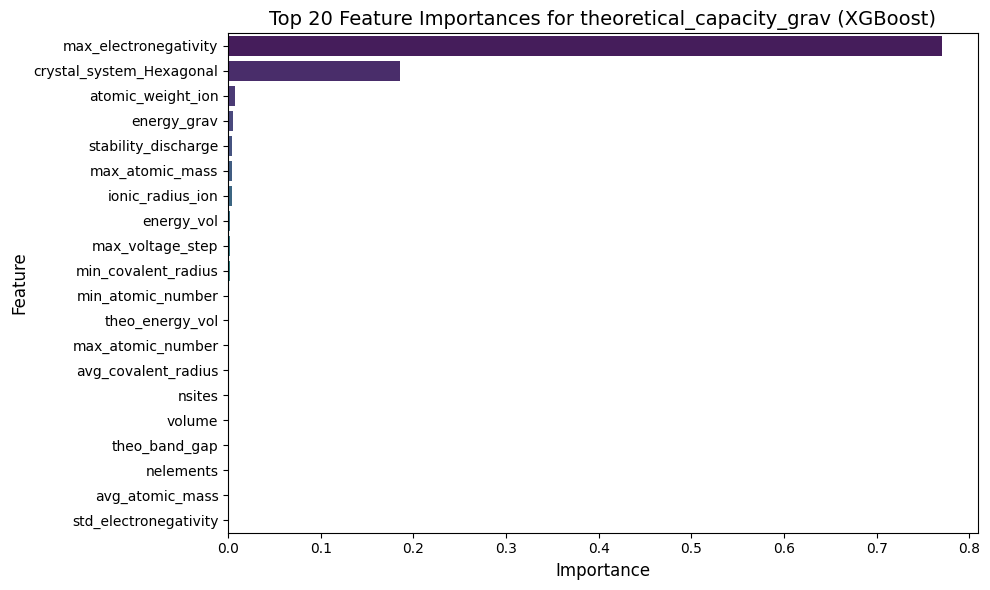

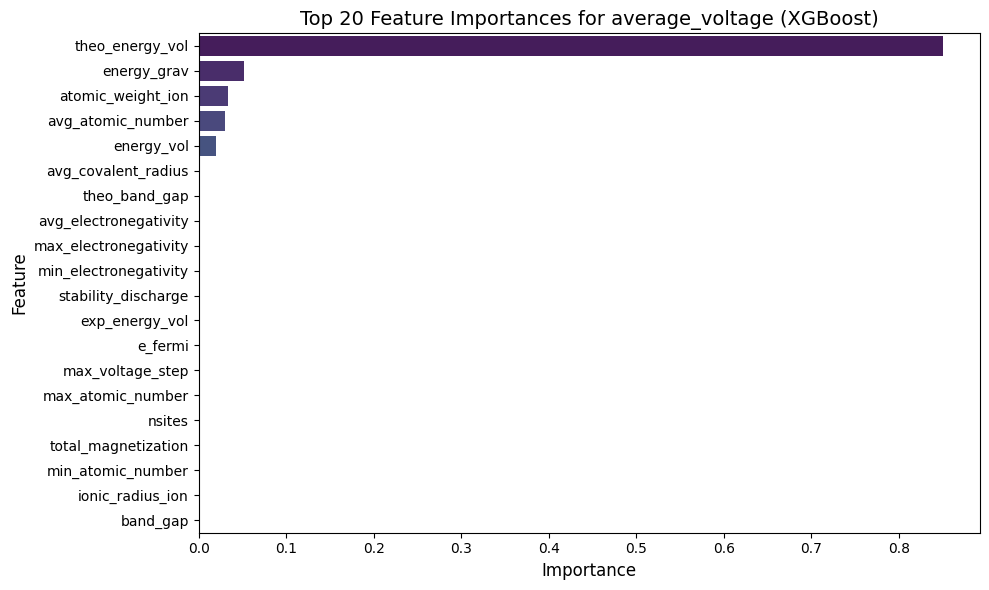

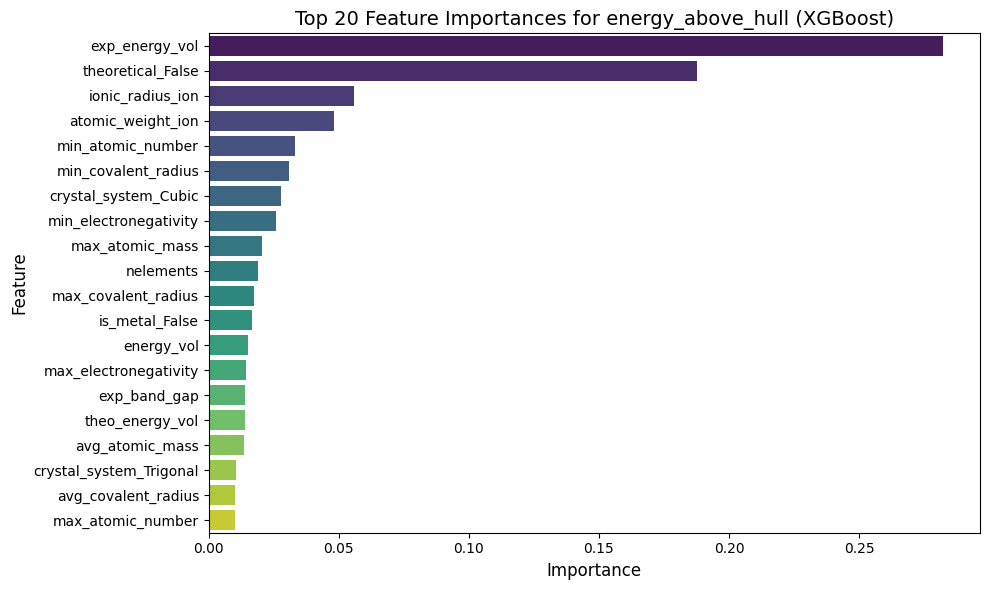


--- Plotting Average Feature Importances Across All KPIs for XGBoost ---


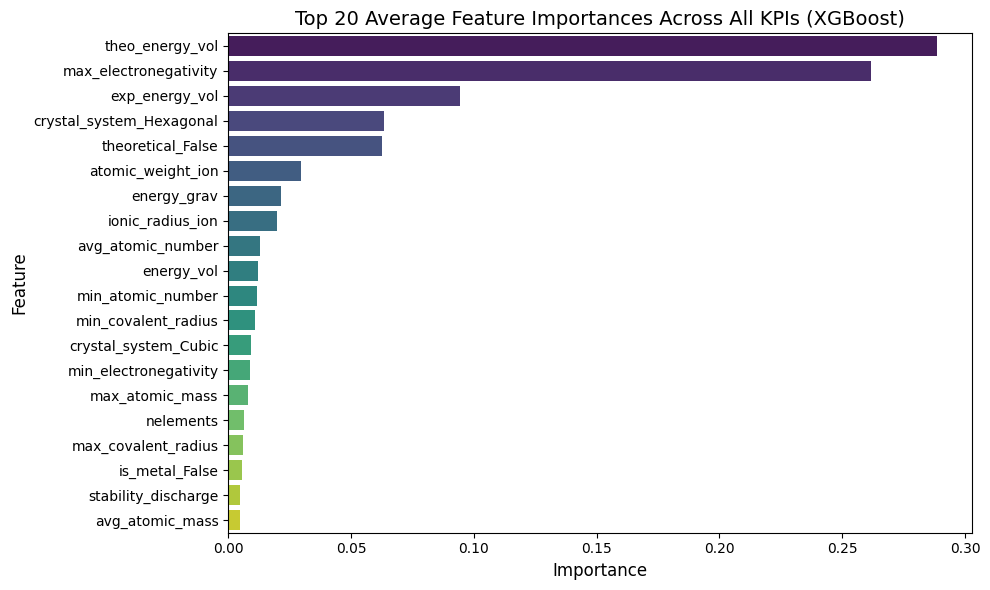


--- Plotting Feature Importances for Random Forest ---

--- Plotting Feature Importances per KPI for Random Forest ---


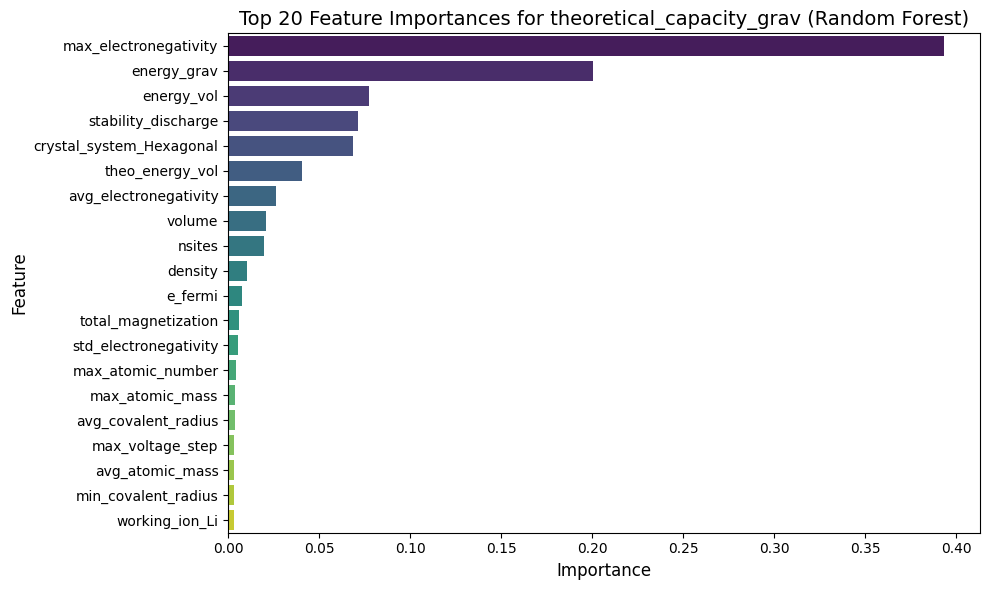

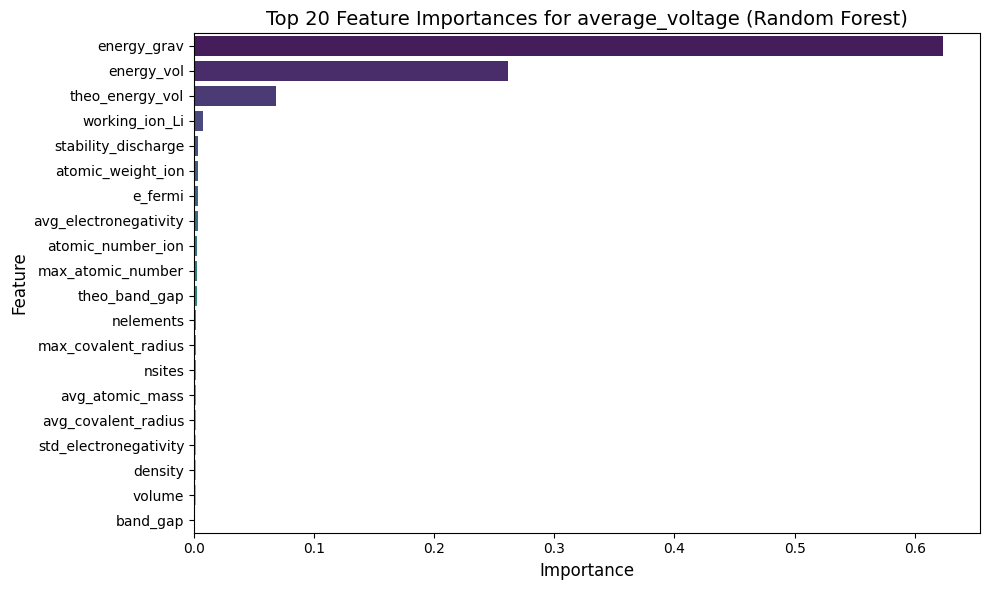

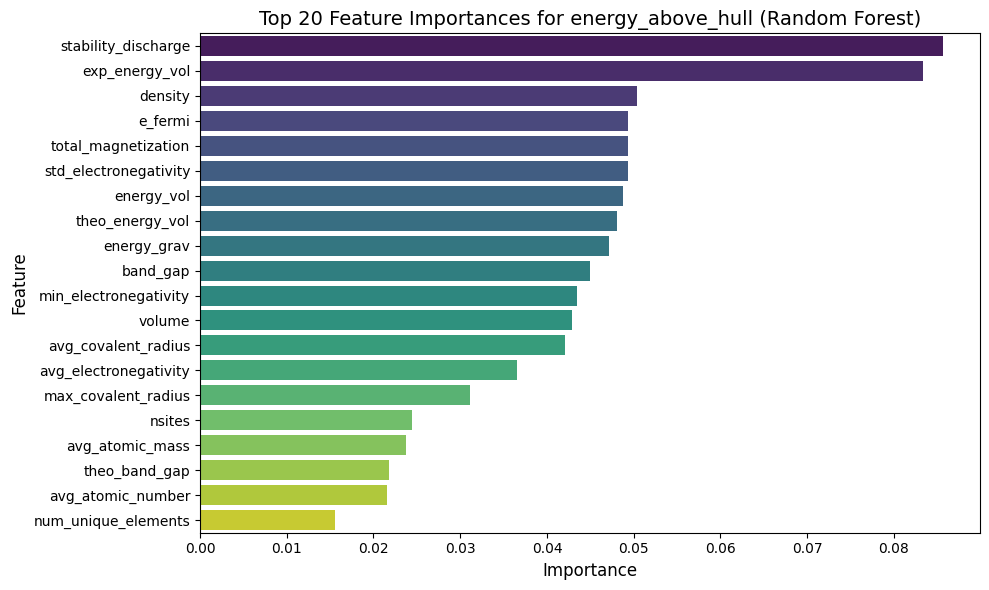


--- Plotting Average Feature Importances Across All KPIs for Random Forest ---


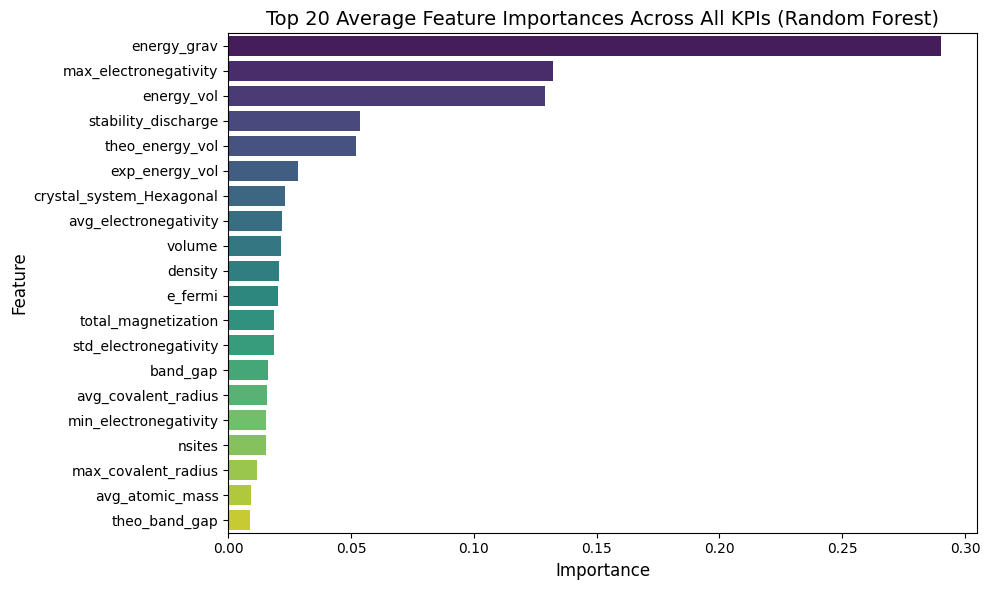


--- Plotting Feature Importances for LightGBM ---

--- Plotting Feature Importances per KPI for LightGBM ---


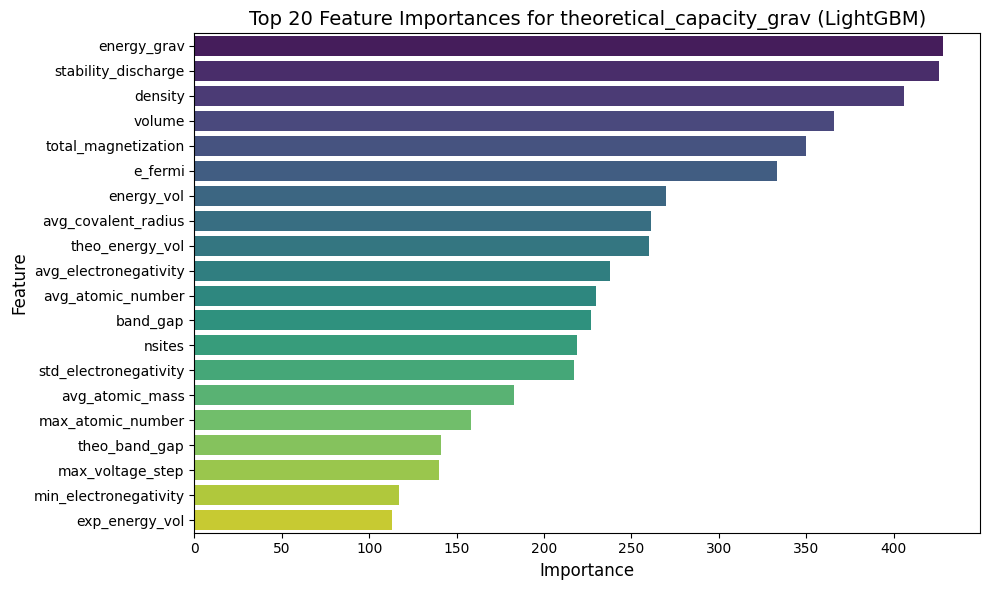

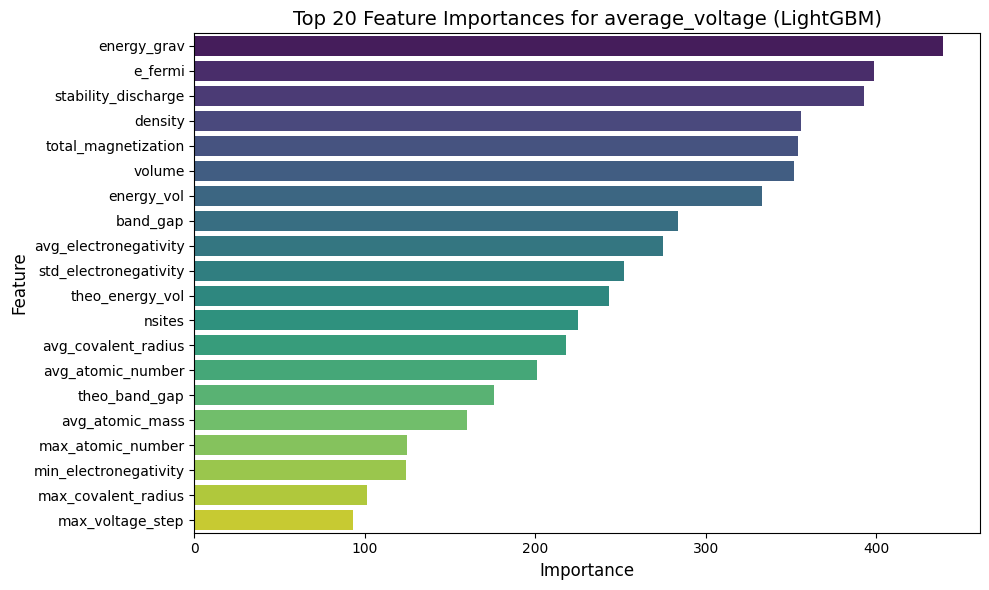

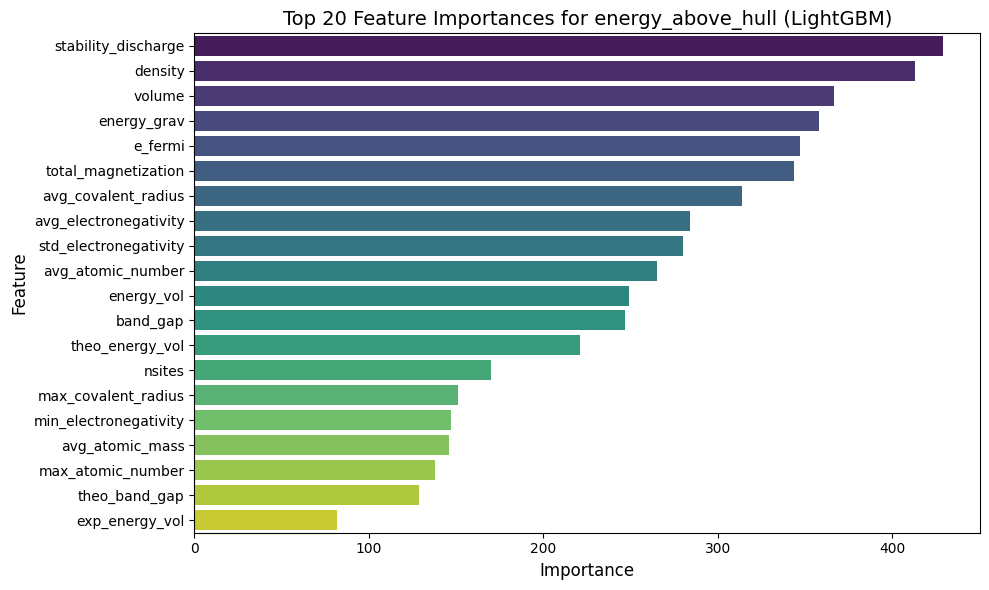


--- Plotting Average Feature Importances Across All KPIs for LightGBM ---


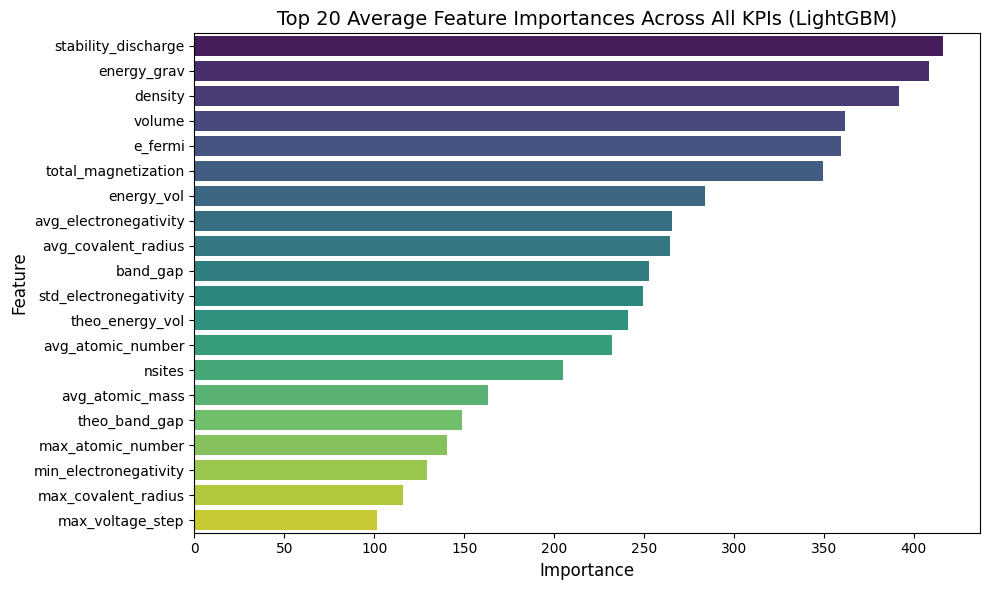


--- Feature Importance Plotting Complete ---


In [ ]:
# Function to plot feature importances
def plot_feature_importances(df, importance_col, title, top_n=20):
    """Plots the top N feature importances from a DataFrame."""
    plt.figure(figsize=(10, 6))
    # Corrected palette usage to avoid FutureWarning
    sns.barplot(x=importance_col, y='Feature', data=df.head(top_n), palette='viridis', hue='Feature', legend=False)
    plt.title(title, fontsize=14)
    plt.xlabel("Importance", fontsize=12)
    plt.ylabel("Feature", fontsize=12)
    plt.tight_layout()
    plt.show()

# Plot importances for each model
if 'all_models_importance_results' in locals() and all_models_importance_results:
    print("\n--- Plotting Feature Importances for Each Model ---")

    for model_name, importance_df_model in all_models_importance_results.items():
        print(f"\n--- Plotting Feature Importances for {model_name} ---")

        # Plot importances for each KPI within this model (if available)
        kpi_importance_cols = [col for col in importance_df_model.columns if col.startswith('Importance_')]
        if kpi_importance_cols:
             print(f"\n--- Plotting Feature Importances per KPI for {model_name} ---")
             for importance_col in kpi_importance_cols:
                 kpi = importance_col.replace('Importance_', '') # Extract KPI name
                 if importance_col in importance_df_model.columns:
                     # Sort the model's importance df by the current KPI's importance
                     df_to_plot = importance_df_model.sort_values(by=importance_col, ascending=False).reset_index(drop=True)
                     plot_feature_importances(df_to_plot, importance_col, f'Top 20 Feature Importances for {kpi} ({model_name})')
                 else:
                     print(f"  Cannot plot importance for {kpi} ({model_name}) as data is not available.")

        # Plot average importances across all KPIs for this model (if available)
        if 'Average_Importance' in importance_df_model.columns:
            print(f"\n--- Plotting Average Feature Importances Across All KPIs for {model_name} ---")
            # The DataFrame stored in all_models_importance_results for MultiOutputRegressors
            # is already sorted by Average_Importance if it exists.
            plot_feature_importances(importance_df_model, 'Average_Importance', f'Top 20 Average Feature Importances Across All KPIs ({model_name})')
        # Handle models that might not be MultiOutputRegressor but have direct importance
        # This part assumes the single importance column is named 'Importance_<ModelName>'
        elif len(kpi_importance_cols) == 1 and f'Importance_{model_name}' in importance_df_model.columns:
             print(f"\n--- Plotting Feature Importances for {model_name} (Single Output) ---")
             plot_feature_importances(importance_df_model, f'Importance_{model_name}', f'Top 20 Feature Importances ({model_name})')


else:
    print("\nFeature importance results not found. Cannot generate plots.")
    print("Please ensure the feature importance calculation cell (PNn3cFy8Zie7) was run successfully.")

print("\n--- Feature Importance Plotting Complete ---")

## Feature Reduction (based on feature importance)

In [ ]:
print("\n--- Identifying Top 20 Features per Model ---")

N_FEATURES_PER_MODEL = 20 # Define the number of top features to keep for *each* model

top_features_per_model = {} # Dictionary to store the list of top features for each model

# Ensure all_models_importance_results is available
if 'all_models_importance_results' in locals() and all_models_importance_results:

    print(f"Identifying top {N_FEATURES_PER_MODEL} features for each of the {len(all_models_importance_results)} models.")

    for model_name, importance_df_model in all_models_importance_results.items():
        print(f"\n--- Identifying Top Features for {model_name} ---")

        importance_col = None
        if 'Average_Importance' in importance_df_model.columns:
            importance_col = 'Average_Importance'
            print(f"  Using Average Importance across KPIs for {model_name}.")
        elif 'Importance' in importance_df_model.columns:
             importance_col = 'Importance'
             print(f"  Using direct Importance for {model_name}.")
        else:
             print(f"  Could not find a suitable importance column for {model_name}. Skipping.")


        if importance_col and importance_col in importance_df_model.columns:
            # Sort by importance and get top features
            importance_df_sorted = importance_df_model.sort_values(by=importance_col, ascending=False).reset_index(drop=True)
            top_features_list = importance_df_sorted['Feature'].head(N_FEATURES_PER_MODEL).tolist()

            top_features_per_model[model_name] = top_features_list

            print(f"\nTop {N_FEATURES_PER_MODEL} Features for {model_name}:")
            print(top_features_list)

        else:
            print(f"  No valid importance data available for {model_name} after sorting. Skipping feature identification for this model.")


    # Save the dictionary of top features per model
    top_features_per_model_filename = os.path.join(model_folder_path, f"top_{N_FEATURES_PER_MODEL}_features_per_model.joblib")
    joblib.dump(top_features_per_model, top_features_per_model_filename)
    print(f"\nDictionary of top features per model saved to '{top_features_per_model_filename}'")

    print("\nFeature Identification per Model Complete.")

else:
  print("\nCould not identify top features per model.")
  print("Feature importance results ('all_models_importance_results') not found.")
  print("Please ensure the feature importance calculation cell was run successfully.")
  top_features_per_model = {} # Ensure the dictionary is empty if importance results are missing



--- Identifying Top 20 Features per Model ---
Identifying top 20 features for each of the 3 models.

--- Identifying Top Features for XGBoost ---
  Using Average Importance across KPIs for XGBoost.

Top 20 Features for XGBoost:
['theo_energy_vol', 'max_electronegativity', 'exp_energy_vol', 'crystal_system_Hexagonal', 'theoretical_False', 'atomic_weight_ion', 'energy_grav', 'ionic_radius_ion', 'avg_atomic_number', 'energy_vol', 'min_atomic_number', 'min_covalent_radius', 'crystal_system_Cubic', 'min_electronegativity', 'max_atomic_mass', 'nelements', 'max_covalent_radius', 'is_metal_False', 'stability_discharge', 'avg_atomic_mass']

--- Identifying Top Features for Random Forest ---
  Using Average Importance across KPIs for Random Forest.

Top 20 Features for Random Forest:
['energy_grav', 'max_electronegativity', 'energy_vol', 'stability_discharge', 'theo_energy_vol', 'exp_energy_vol', 'crystal_system_Hexagonal', 'avg_electronegativity', 'volume', 'density', 'e_fermi', 'total_magneti

In [ ]:
# --- Train New Models on Their Respective Top Features ---
print("\n--- Training New Models on Their Respective Top Features ---")

# Ensure original training data and top_features_per_model are available
all_components_available = (
    'X_train_loaded_df_full' in locals() and not X_train_loaded_df_full.empty and
    'Y_train_loaded_df' in locals() and not Y_train_loaded_df.empty and
    'top_features_per_model' in locals() and top_features_per_model is not None
)

if all_components_available:

    trained_models_selected_features = {} # Dictionary to store the newly trained models

    # Define base models for training (using the same hyperparameters as before)
    # Set verbose to -1 to suppress LightGBM output
    base_xgboost_model = XGBRegressor(random_state=9, n_estimators=250, learning_rate=0.2,
                             max_depth=10, subsample=0.9, colsample_bytree=0.9,
                             gamma=0, reg_alpha=0.001, reg_lambda=0.001,
                             tree_method='hist', n_jobs=-1)

    base_random_forest_model = RandomForestRegressor(random_state=9, n_estimators=500, max_depth=10,
                                                     min_samples_split=5, min_samples_leaf=2, n_jobs=-1)

    # Set verbose to -1 to suppress LightGBM output
    base_lightgbm_model = LGBMRegressor(random_state=9, n_estimators=1000, learning_rate=0.05,
                                        num_leaves=31, max_depth=-1, reg_alpha=0.1,
                                        reg_lambda=0.1, colsample_bytree=0.8, subsample=0.8, n_jobs=-1,
                                        verbose=-1) # Added verbose=-1


    # Create MultiOutputRegressor versions of the base models
    multioutput_xgboost = MultiOutputRegressor(base_xgboost_model)
    multioutput_random_forest = MultiOutputRegressor(base_random_forest_model)
    multioutput_lightgbm = MultiOutputRegressor(base_lightgbm_model)

    # Map model names to their base MultiOutputRegressor instances
    models_to_train = {
        'XGBoost': multioutput_xgboost,
        'Random Forest': multioutput_random_forest,
        'LightGBM': multioutput_lightgbm
    }


    for model_name, model_instance in models_to_train.items():
        print(f"\n--- Training New {model_name} Model on Its Top Features ---")

        # Get the top features specifically for this model
        if model_name in top_features_per_model and top_features_per_model[model_name]:
            model_specific_features = top_features_per_model[model_name]
            print(f"  Using {len(model_specific_features)} top features for training.")

            # Filter the training data to include only the model-specific top features
            # Ensure all model-specific features are in the original training dataframe columns
            valid_model_specific_features = [f for f in model_specific_features if f in X_train_loaded_df_full.columns]

            if len(valid_model_specific_features) != len(model_specific_features):
                 print(f"\nWarning: {len(model_specific_features) - len(valid_model_specific_features)} selected features were not found in the original training dataframe columns.")
                 print("Only valid features will be used for training.")

            if valid_model_specific_features:
                 X_train_filtered = X_train_loaded_df_full[valid_model_specific_features]
                 Y_train_filtered = Y_train_loaded_df.copy() # Targets remain the same

                 # Train the new model instance
                 print(f"  Starting training of new {model_name} model...")
                 # MultiOutputRegressor doesn't have a verbose parameter, it passes it to the base estimator
                 model_instance.fit(X_train_filtered, Y_train_filtered)
                 print(f"  Training complete for new {model_name} model.")

                 # Store the newly trained model
                 trained_models_selected_features[model_name] = model_instance
                 print(f"  New {model_name} model trained and stored.")

            else:
                print(f"  No valid top features found in the training data columns for {model_name}. Cannot train.")
        else:
            print(f"  Top features for {model_name} not found in 'top_features_per_model' dictionary or list is empty. Cannot train.")

    if trained_models_selected_features:
        print("\n--- Training of New Models on Respective Top Features Complete ---")
        print(f"Successfully trained and stored {len(trained_models_selected_features)} models.")
        # The newly trained models are stored in the 'trained_models_selected_features' dictionary
    else:
        print("\nNo new models were trained on selected features.")


else:
    print("\nTraining skipped.")
    if 'X_train_loaded_df_full' not in locals() or X_train_loaded_df_full.empty:
        print("  Reason: X_train_loaded_df_full is not available or empty.")
    if 'Y_train_loaded_df' not in locals() or Y_train_loaded_df.empty:
        print("  Reason: Y_train_loaded_df is not available or empty.")
    if 'top_features_per_model' not in locals() or top_features_per_model is None:
         print("  Reason: 'top_features_per_model' dictionary not found.")


--- Training New Models on Their Respective Top Features ---

--- Training New XGBoost Model on Its Top Features ---
  Using 20 top features for training.
  Starting training of new XGBoost model...
  Training complete for new XGBoost model.
  New XGBoost model trained and stored.

--- Training New Random Forest Model on Its Top Features ---
  Using 20 top features for training.
  Starting training of new Random Forest model...
  Training complete for new Random Forest model.
  New Random Forest model trained and stored.

--- Training New LightGBM Model on Its Top Features ---
  Using 20 top features for training.
  Starting training of new LightGBM model...
  Training complete for new LightGBM model.
  New LightGBM model trained and stored.

--- Training of New Models on Respective Top Features Complete ---
Successfully trained and stored 3 models.


In [ ]:
print("\n--- Evaluating Newly Trained Models on the Entire Test Set (Selected Features) ---")

# Ensure the newly trained models and the test data are available
components_for_evaluation_available = (
    'trained_models_selected_features' in locals() and trained_models_selected_features and
    'X_test_loaded_df_full' in locals() and not X_test_loaded_df_full.empty and
    'Y_test_loaded_df' in locals() and not Y_test_loaded_df.empty and
    'top_features_per_model' in locals() and top_features_per_model is not None and top_features_per_model
)

if components_for_evaluation_available:

    evaluation_results_selected_features = {} # Dictionary to store metrics for the new models

    for model_name, model in trained_models_selected_features.items():
        print(f"\n--- Evaluating New {model_name} Model ---")

        # Get the specific features this model was trained on
        if model_name in top_features_per_model and top_features_per_model[model_name]:
            model_specific_features = top_features_per_model[model_name]
            print(f"  Using {len(model_specific_features)} features for prediction.")

            # Filter the test data to include only the model-specific top features
            # Ensure all model-specific features are in the original test dataframe columns
            valid_model_specific_features_test = [f for f in model_specific_features if f in X_test_loaded_df_full.columns]

            if len(valid_model_specific_features_test) != len(model_specific_features):
                 print(f"\nWarning: {len(model_specific_features) - len(valid_model_specific_features_test)} selected features were not found in the test dataframe columns for {model_name}.")
                 print("Only valid features will be used for prediction.")

            if valid_model_specific_features_test:

                X_test_filtered_scaled = X_test_loaded_df_full[valid_model_specific_features_test]
                y_test_evaluation_new_models = Y_test_loaded_df.copy() # Targets remain the same

                # Make predictions
                print(f"  Predicting with new {model_name} on test set of shape: {X_test_filtered_scaled.shape}")
                y_pred_new_model = model.predict(X_test_filtered_scaled)
                print("  Prediction complete.")

                # Calculate metrics for each target KPI
                print(f"\n  --- Performance Metrics for New {model_name} ---")

                results_new_model = {}

                for i, kpi in enumerate(target_kpis):
                    actual = y_test_evaluation_new_models[kpi]
                    predicted = y_pred_new_model[:, i] # Select the predictions for the i-th target

                    # Calculate metrics
                    r2 = r2_score(actual, predicted)
                    mae = mean_absolute_error(actual, predicted)
                    rmse = np.sqrt(mean_squared_error(actual, predicted)) # Calculate RMSE

                    print(f"\n  Metrics for KPI: {kpi}")
                    print(f"    R2 Score: {r2:.4f}")
                    print(f"    MAE:      {mae:.4f}")
                    print(f"    RMSE:     {rmse:.4f}")

                    # Store results
                    results_new_model[kpi] = {
                        'R2 Score': r2,
                        'MAE': mae,
                        'RMSE': rmse,
                    }

                print(f"\n  --- Average Performance Metrics (New {model_name}) ---")
                avg_r2 = np.mean([res['R2 Score'] for res in results_new_model.values()])
                avg_mae = np.mean([res['MAE'] for res in results_new_model.values()])
                avg_rmse = np.mean([res['RMSE'] for res in results_new_model.values()])


                print(f"    Average R2 Score: {avg_r2:.4f}")
                print(f"    Average MAE:      {avg_mae:.4f}")
                print(f"    Average RMSE:     {avg_rmse:.4f}")

                # Store metrics for this new model
                evaluation_results_selected_features[f'{model_name}_SelectedFeatures'] = pd.DataFrame(results_new_model).T


            else:
                 print(f"  No valid top features found in the test data columns for {model_name}. Cannot evaluate.")

        else:
            print(f"  Top features for {model_name} not found in 'top_features_per_model' dictionary or list is empty. Cannot evaluate.")


    if evaluation_results_selected_features:
        print("\n--- Overall Metrics Summary DataFrame (New Models) ---")
        # Combine all new metrics DataFrames into a single DataFrame
        combined_new_metrics_df = pd.concat(evaluation_results_selected_features, axis=1)
        display(combined_new_metrics_df)
    else:
        print("\nNo evaluation results available for the new models.")

else:
    print("\nEvaluation of newly trained models skipped.")
    if 'trained_models_selected_features' not in locals() or not trained_models_selected_features:
        print("  Reason: No new models ('trained_models_selected_features') found.")
    if 'X_test_loaded_df_full' not in locals() or X_test_loaded_df_full.empty:
        print("  Reason: X_test_loaded_df_full is not available or empty.")
    if 'Y_test_loaded_df' not in locals() or Y_test_loaded_df.empty:
        print("  Reason: Y_test_loaded_df is not available or empty.")
    if 'top_features_per_model' not in locals() or top_features_per_model is None or not top_features_per_model:
         print("  Reason: 'top_features_per_model' dictionary not found or is empty.")




--- Evaluating Newly Trained Models on the Entire Test Set (Selected Features) ---

--- Evaluating New XGBoost Model ---
  Using 20 features for prediction.
  Predicting with new XGBoost on test set of shape: (689, 20)
  Prediction complete.

  --- Performance Metrics for New XGBoost ---

  Metrics for KPI: theoretical_capacity_grav
    R2 Score: 0.7094
    MAE:      22.2518
    RMSE:     38.5063

  Metrics for KPI: average_voltage
    R2 Score: 0.9115
    MAE:      0.4256
    RMSE:     1.1788

  Metrics for KPI: energy_above_hull
    R2 Score: 0.4187
    MAE:      0.0256
    RMSE:     0.0351

  --- Average Performance Metrics (New XGBoost) ---
    Average R2 Score: 0.6799
    Average MAE:      7.5677
    Average RMSE:     13.2401

--- Evaluating New Random Forest Model ---
  Using 20 features for prediction.
  Predicting with new Random Forest on test set of shape: (689, 20)
  Prediction complete.

  --- Performance Metrics for New Random Forest ---

  Metrics for KPI: theoretical_ca

XGBoost_SelectedFeatures                        \
                                          R2 Score        MAE       RMSE   
theoretical_capacity_grav                 0.709416  22.251813  38.506345   
average_voltage                           0.911522   0.425595   1.178840   
energy_above_hull                         0.418710   0.025628   0.035145   

                          Random Forest_SelectedFeatures             \
                                                R2 Score        MAE   
theoretical_capacity_grav                       0.560891  24.969863   
average_voltage                                 0.679945   0.534930   
energy_above_hull                               0.377979   0.027039   

                                     LightGBM_SelectedFeatures             \
                                RMSE                  R2 Score        MAE   
theoretical_capacity_grav  47.334989                  0.363503  24.332425   
average_voltage             2.242068                  0.661875   0.786553   
energy_above_hull           0.036356                  0.502398   0.023911   

                                      
                                RMSE  
theoretical_capacity_grav  56.989439  
average_voltage             2.304489  
energy_above_hull           0.032517

In [ ]:
# Quick Model Test: Predict for a Random Material ID (using the NEW 20-feature models)
print("\n--- Quick Model Test on a Random Material (Newly Trained Models on Selected Features) ---")

try:
    # Ensure the newly trained models are available
    if 'trained_models_selected_features' in locals() and trained_models_selected_features:

        # Choose a random index from the test set (use the same index for all models for comparison)
        # Ensure X_test_loaded_df_full is available
        if 'X_test_loaded_df_full' in locals() and not X_test_loaded_df_full.empty:

            random_idx = random.randint(0, X_test_loaded_df_full.shape[0] - 1)

            # Get the material ID and formula for this random index
            test_material_id = material_ids.iloc[random_idx]
            test_formula_pretty = formula_pretties.iloc[random_idx]

            print(f"Testing prediction for Random Material ID: {test_material_id}")
            print(f"Formula: {test_formula_pretty}")
            print(f"Using test set index: {random_idx}")

            # Get the actual KPIs for comparison (using the original full test set targets)
            actual_kpis = Y_test_loaded_df.iloc[random_idx].values # .values to get numpy array

            # Display results
            print("\n--- Results for Randomly Selected Material (Newly Trained Models) ---")
            print(f"Material ID: {test_material_id}")
            print(f"Formula: {test_formula_pretty}")
            print(f"Actual KPIs:")
            for i, kpi in enumerate(target_kpis):
                print(f"  {kpi}: {actual_kpis[i]:.4f}")

            print("\n--- Predicted KPI Comparisons ---")
            for model_name, model in trained_models_selected_features.items():
                print(f"\n--- {model_name} (Selected Features) Predictions ---")
                try:
                    # Get the specific features this model was trained on
                    if model_name in top_features_per_model and top_features_per_model[model_name]:
                        model_specific_features = top_features_per_model[model_name]

                        # Filter the test data for this specific material using the model's features
                        # Ensure features exist in the original test dataframe columns
                        valid_model_specific_features_test = [f for f in model_specific_features if f in X_test_loaded_df_full.columns]

                        if valid_model_specific_features_test:
                             material_scaled_features_filtered = X_test_loaded_df_full.iloc[random_idx:random_idx+1][valid_model_specific_features_test]

                             # Make the prediction using the current model
                             predicted_kpis = model.predict(material_scaled_features_filtered)[0] # [0] to get the single array of predictions

                             for i, kpi in enumerate(target_kpis):
                                 predicted = predicted_kpis[i]
                                 actual = actual_kpis[i]

                                 print(f"  {kpi}:")
                                 print(f"    Predicted: {predicted:.4f}")

                                 # Calculate and display Absolute Error
                                 absolute_error = abs(predicted - actual)
                                 print(f"    Absolute Error: {absolute_error:.4f}")

                                 # Calculate and display Relative Error (Percentage Error)
                                 if actual != 0:
                                     relative_error_percent = ((predicted - actual) / actual) * 100
                                     print(f"    Relative Error: {relative_error_percent:.2f}%")
                                 else:
                                     print(f"    Relative Error: N/A (Actual KPI is zero)")
                        else:
                             print(f"  Error: No valid selected features found in test data for {model_name}. Cannot predict.")
                             print("  Please check 'top_features_per_model' and X_test_loaded_df_full columns.")
                             # Print placeholder results if prediction fails
                             for i, kpi in enumerate(target_kpis):
                                 print(f"  {kpi}: Prediction Failed")


                    else:
                        print(f"  Error: Top features for {model_name} not found. Cannot predict.")
                        # Print placeholder results if prediction fails
                        for i, kpi in enumerate(target_kpis):
                            print(f"  {kpi}: Prediction Failed")


                except Exception as e:
                    print(f"  Error predicting with {model_name}: {e}")
                    # Print placeholder results if prediction fails
                    for i, kpi in enumerate(target_kpis):
                         print(f"  {kpi}: Prediction Error")


        else:
            print("\nQuick model test skipped.")
            print("  Reason: X_test_loaded_df_full data not available or empty.")
            print("  Please ensure test data is loaded correctly.")


    else:
        print("\nQuick model test skipped.")
        print("  Reason: 'trained_models_selected_features' dictionary not found or is empty.")
        print("  Please ensure the 'Train New Models on Their Respective Top Features' cell was run successfully.")


except Exception as e:
    print("\nAn unexpected error occurred during the quick model test.")
    print(f"  Error: {e}")



--- Quick Model Test on a Random Material (Newly Trained Models on Selected Features) ---
Testing prediction for Random Material ID: mp-781672
Formula: LiFeH8(SO6)2
Using test set index: 154

--- Results for Randomly Selected Material (Newly Trained Models) ---
Material ID: mp-781672
Formula: LiFeH8(SO6)2
Actual KPIs:
  theoretical_capacity_grav: 80.2648
  average_voltage: 2.7832
  energy_above_hull: 0.0346

--- Predicted KPI Comparisons ---

--- XGBoost (Selected Features) Predictions ---
  theoretical_capacity_grav:
    Predicted: 78.6587
    Absolute Error: 1.6061
    Relative Error: -2.00%
  average_voltage:
    Predicted: 3.4882
    Absolute Error: 0.7051
    Relative Error: 25.33%
  energy_above_hull:
    Predicted: 0.0248
    Absolute Error: 0.0098
    Relative Error: -28.20%

--- Random Forest (Selected Features) Predictions ---
  theoretical_capacity_grav:
    Predicted: 89.5272
    Absolute Error: 9.2624
    Relative Error: 11.54%
  average_voltage:
    Predicted: 2.1875
   

## Save new models and data

In [ ]:
# Save the Newly Trained Models and Data
print("\n--- Saving Newly Trained Models and Data ---")

# Define paths for saving the newly trained models and data
models_selected_features_folder = '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Model_Selected_Features'
data_selected_features_folder = '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Data/Training_Data_Selected_Features'

# Create folders if they don't exist
os.makedirs(models_selected_features_folder, exist_ok=True)
os.makedirs(data_selected_features_folder, exist_ok=True)
print(f"Ensured '{models_selected_features_folder}' and '{data_selected_features_folder}' folders exist.")


# Ensure the necessary components are available
components_for_saving_available = (
    'trained_models_selected_features' in locals() and trained_models_selected_features and
    'X_train_loaded_df_full' in locals() and not X_train_loaded_df_full.empty and
    'Y_train_loaded_df' in locals() and not Y_train_loaded_df.empty and
    'X_test_loaded_df_full' in locals() and not X_test_loaded_df_full.empty and
    'Y_test_loaded_df' in locals() and not Y_test_loaded_df.empty and
    'top_features_per_model' in locals() and top_features_per_model is not None and top_features_per_model
)

if components_for_saving_available:

    print("\n--- Saving Models ---")
    for model_name, model in trained_models_selected_features.items():
        try:
            # Define the filename for the model
            model_save_filename = os.path.join(models_selected_features_folder, f"{model_name.replace(' ', '_').lower()}_selected_features_model_v2.joblib")
            joblib.dump(model, model_save_filename)
            print(f"Saved new '{model_name}' model to '{model_save_filename}'")
        except Exception as e:
            print(f"Error saving '{model_name}' model: {e}")

    print("\n--- Saving Data with Selected Features ---")

    # Iterate through the models to save their specific feature subsets of the data
    for model_name, features_list in top_features_per_model.items():
        try:
            if features_list:
                print(f"\nSaving data subsets for features selected by '{model_name}'")

                # Filter Training Data
                # Ensure features are present in the original training data before selecting
                valid_train_features = [f for f in features_list if f in X_train_loaded_df_full.columns]
                # Add 'formula_pretty' to the list of columns to keep if it exists in the original data
                cols_to_keep_train = valid_train_features + ['formula_pretty'] if 'formula_pretty' in X_train_loaded_df_full.columns else valid_train_features

                if cols_to_keep_train:
                    X_train_filtered = X_train_loaded_df_full[cols_to_keep_train]
                    train_data_save_filename = os.path.join(data_selected_features_folder, f"X_train_scaled_{model_name.replace(' ', '_').lower()}_features_with_formula_v2.csv")
                    X_train_filtered.to_csv(train_data_save_filename, index=True) # Save index as well if it contains identifiers
                    print(f"Saved filtered X_train_scaled for '{model_name}' to '{train_data_save_filename}' (Shape: {X_train_filtered.shape})")
                else:
                    print(f"  No valid features found in original X_train for '{model_name}'. X_train data not saved for this model.")


                # Filter Test Data
                 # Ensure features are present in the original test data before selecting
                valid_test_features = [f for f in features_list if f in X_test_loaded_df_full.columns]
                 # Add 'formula_pretty' to the list of columns to keep if it exists in the original data
                cols_to_keep_test = valid_test_features + ['formula_pretty'] if 'formula_pretty' in X_test_loaded_df_full.columns else valid_test_features

                if cols_to_keep_test:
                    X_test_filtered = X_test_loaded_df_full[cols_to_keep_test]
                    test_data_save_filename = os.path.join(data_selected_features_folder, f"X_test_scaled_{model_name.replace(' ', '_').lower()}_features_with_formula_v2.csv")
                    X_test_filtered.to_csv(test_data_save_filename, index=True) # Save index as well if it contains identifiers
                    print(f"Saved filtered X_test_scaled for '{model_name}' to '{test_data_save_filename}' (Shape: {X_test_filtered.shape})")
                else:
                     print(f"  No valid features found in original X_test for '{model_name}'. X_test data not saved for this model.")

            else:
                print(f"  No features listed for '{model_name}' in 'top_features_per_model'. Data not saved for this model.")

        except Exception as e:
            print(f"Error saving data subsets for '{model_name}' features: {e}")


    # Save the Y_train and Y_test data (they are the same for all models)
    try:
        y_train_save_filename = os.path.join(data_selected_features_folder, "Y_train_v2.csv")
        Y_train_loaded_df.to_csv(y_train_save_filename, index=True) # Save index
        print(f"Saved Y_train data to '{y_train_save_filename}' (Shape: {Y_train_loaded_df.shape})")

        y_test_save_filename = os.path.join(data_selected_features_folder, "Y_test_v2.csv")
        Y_test_loaded_df.to_csv(y_test_save_filename, index=True) # Save index
        print(f"Saved Y_test data to '{y_test_save_filename}' (Shape: {Y_test_loaded_df.shape})")

    except Exception as e:
         print(f"Error saving Y_train or Y_test data: {e}")

    # Save the scaler in the models_selected_features_folder
    print("\n--- Saving Scaler ---")
    try:
        # Define the scaler filename within the models_selected_features_folder
        scaler_save_filename = os.path.join(models_selected_features_folder, "scaler_X_v2.joblib")
        joblib.dump(loaded_scaler_X, scaler_save_filename)
        print(f"Scaler saved successfully to '{scaler_save_filename}'")
    except NameError:
        print("Error: 'loaded_scaler_X' is not defined. Please ensure the scaler was loaded previously.")
    except Exception as e:
        print(f"Error saving scaler: {e}")

    # Save the top_features_per_model dictionary
    print("\n--- Saving Top Features per Model ---")
    try:
        top_features_save_filename = os.path.join(models_selected_features_folder, "top_features_per_model_v2.joblib")
        joblib.dump(top_features_per_model, top_features_save_filename)
        print(f"'top_features_per_model' dictionary saved successfully to '{top_features_save_filename}'")
    except NameError:
        print("Error: 'top_features_per_model' is not defined. Please ensure top features were identified.")
    except Exception as e:
        print(f"Error saving top_features_per_model: {e}")


    print("\n--- Saving Complete ---")


else:
    print("\nSaving skipped.")
    if 'trained_models_selected_features' not in locals() or not trained_models_selected_features:
        print("  Reason: No new models ('trained_models_selected_features') found.")
    if 'X_train_loaded_df_full' not in locals() or X_train_loaded_df_full.empty:
        print("  Reason: X_train_loaded_df_full is not available or empty.")
    if 'Y_train_loaded_df' not in locals() or Y_train_loaded_df.empty:
        print("  Reason: Y_train_loaded_df is not available or empty.")
    if 'X_test_loaded_df_full' not in locals() or X_test_loaded_df_full.empty:
        print("  Reason: X_test_loaded_df_full is not available or empty.")
    if 'Y_test_loaded_df' not in locals() or Y_test_loaded_df.empty:
        print("  Reason: Y_test_loaded_df is not available or empty.")
    if 'top_features_per_model' not in locals() or top_features_per_model is None or not top_features_per_model:
         print("  Reason: 'top_features_per_model' dictionary not found or is empty.")


--- Saving Newly Trained Models and Data ---
Ensured '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Model_Selected_Features' and '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Data/Training_Data_Selected_Features' folders exist.

--- Saving Models ---
Saved new 'XGBoost' model to '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Model_Selected_Features/xgboost_selected_features_model_v2.joblib'
Saved new 'Random Forest' model to '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Model_Selected_Features/random_forest_selected_features_model_v2.joblib'
Saved new 'LightGBM' model to '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Model_Selected_Features/lightgbm_selected_features_model_v2.joblib'

--- Saving Data with Selected Features ---

Saving data subsets for features selected by 'XGBoost'
Saved filtered X_train_scaled for 'XGBoost' to '/content/drive/MyDrive/Colab Notebooks/Masters Research Project/Da

# Appendix: Feature Reduction Workflow

This notebook details a machine learning workflow with the central objective of **feature reduction** for predicting theoretical gravimetric capacity, average voltage, and energy above hull. The goal is to identify and utilize the most relevant features to potentially improve model performance, reduce training time, and enhance interpretability.

Key steps and outcomes are summarized below, framed within this goal:

1.  **Data and Model Loading**
    Pre-processed test data (`X_test_scaled.csv`, `Y_test.csv`), training data (`X_train_scaled.csv`, `Y_train.csv`), pre-trained XGBoost, Random Forest, and LightGBM models (trained on the full 49 features), the `StandardScaler`, and original feature names were loaded. This established the baseline for evaluating the impact of feature reduction.

2.  **Initial Model Performance (Full Features)**
    The performance of the loaded models was evaluated on the complete test set (49 features). This step provided a critical baseline of performance metrics (R2, MAE, RMSE) before any feature reduction was applied.

3.  **Feature Importance Analysis**
    Feature importance was analyzed for each loaded model by accessing the `feature_importances_` of their base estimators. Average importance across KPIs was calculated, and features were sorted. Bar plots visualized the top features, guiding the subsequent feature selection for reduction.

4.  **Model-Specific Feature Identification**
    Based on the average feature importance, the top 20 features most important for each model (XGBoost, Random Forest, LightGBM) were identified and selected. This step implemented the core feature reduction by creating model-specific reduced feature sets. The `top_features_per_model` dictionary storing these lists was saved.

5.  **Training New Models on Selected Features**
    New instances of the XGBoost, Random Forest, and LightGBM models were initialized and trained specifically on their respective **reduced feature sets** identified in the previous step. This created models optimized for prediction using fewer, highly relevant features.

6.  **Evaluating Newly Trained Models on Selected Features**
    The performance of the newly trained models (on selected features) was evaluated on the corresponding reduced test data. This critical step assessed the effectiveness of the feature reduction strategy by comparing the resulting performance metrics (R2, MAE, RMSE) to the initial evaluation on the full feature set.

7.  **Saving Trained Models and Data**
    The newly trained models (on reduced features), the filtered training and test data subsets used for these models, the original scaler, and the `top_features_per_model` dictionary were saved. This persisted the outcomes of the feature reduction workflow for future use.

This appendix summarizes the key steps and outcomes of the notebook, focusing on the process and evaluation of feature reduction for predicting material properties.